<a href="https://colab.research.google.com/github/sausis20/Stock-Price-Prediction/blob/main/Stock_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock price prediction

This is a Machine Learning algorithm to predict if the stock price will increase the next day (tomorrow). We only want to buy the stock on days when the price will go up (we're against shorting the stock). 


*   If the algorithm says that the price will increase, we'll buy the stock
*   If the algorithm says that the price will go down, we won't do anything.


We want to maximize our true positives - days when the algorithm predicts that the price will go up, and it actually goes go up. Therefore, we'll be using precision as our error metric for our algorithm, which is true positives / (false positives + true positives). This will ensure that we minimize how much money we lose with false positives (days when we buy the stock, but the price actually goes down).

This means that we will have to accept a lot of false negatives - days when we predict that the price will go down, but it actually goes up. This is okay, since we'd rather minimize our potential losses than maximize our potential gains.

# Method

* Download historical stock prices from Yahoo finance
* Explore the data
* Setup the dataset to predict future prices using historical prices
* Test a machine learning model
* Setup a backtesting engine
* Improve the accuracy of the model
* Document some potential future directions we can go in to improve the technique

# Downloading the data

In [1]:
!pip install -q yfinance
!pip install --upgrade "kaleido==0.1.*"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
cd '/content/gdrive/My Drive/Colab Notebooks/Stock price prediction/'

/content/gdrive/My Drive/Colab Notebooks/Stock price prediction


In [4]:
import yfinance as yf
import pandas as pd
import os
import kaleido
import plotly.express as px

In [128]:
if os.path.exists("AMZN.csv"):
    # Read from file if we've already downloaded the data
    amazon = pd.read_csv("AMZN.csv", index_col=0)
else:
    amazon_ticker = yf.Ticker("AMZN")
    amazon = amazon_ticker.history(period='max')
    # Save file to .csv in case we need it later. This prevents us from having to re-download it every time.
    amazon.to_csv("AMZN.csv")

In [129]:
amazon.index = pd.to_datetime(amazon.index)
amazon

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1997-05-15,0.121875,0.125000,0.096354,0.097917,1443120000,0,0.0
1997-05-16,0.098438,0.098958,0.085417,0.086458,294000000,0,0.0
1997-05-19,0.088021,0.088542,0.081250,0.085417,122136000,0,0.0
1997-05-20,0.086458,0.087500,0.081771,0.081771,109344000,0,0.0
1997-05-21,0.081771,0.082292,0.068750,0.071354,377064000,0,0.0
...,...,...,...,...,...,...,...
2022-09-14,127.360001,128.839996,126.330002,128.550003,45316800,0,0.0
2022-09-15,127.379997,130.369995,125.500000,126.279999,52887200,0,0.0
2022-09-16,122.779999,123.870003,120.699997,123.529999,115612500,0,0.0


We see Amazon's stock price change in the 25 year period - between 1997 and 2022.

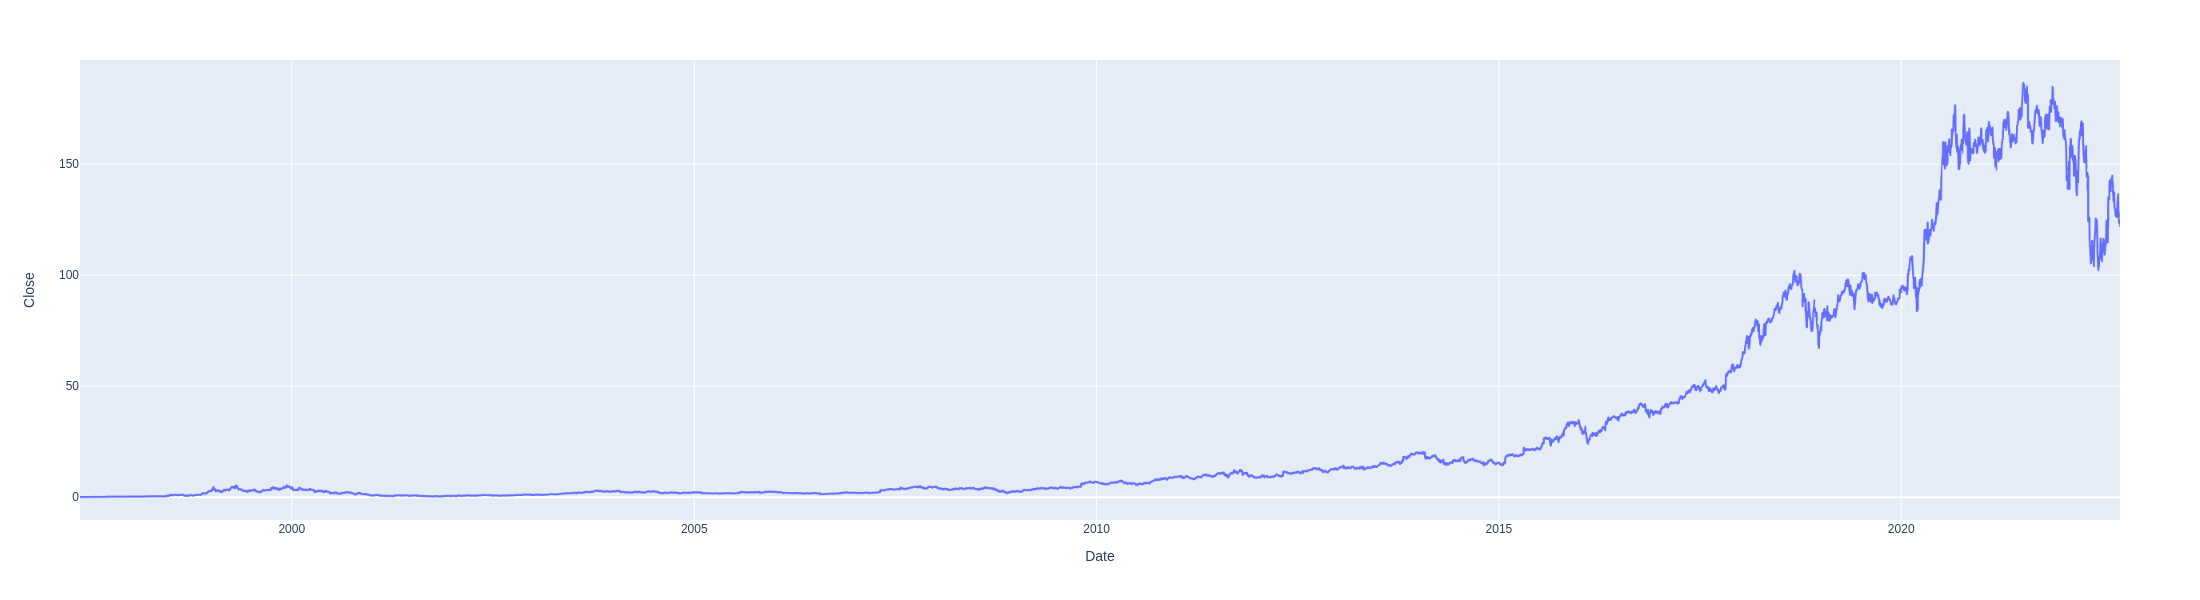

In [130]:
fig = px.line(amazon, y='Close', width=2200, height=600)
fig.show('png')

It would be interesting to see how the stock price changed in the context of major bear markets in the US:
- Dot-com bubble from 2000-03 to 2002-10
- Financial crisis of 2008 from 2007-02 to 2009-03
- Covid-19 lockdowns from 2020-02 to 2020-04

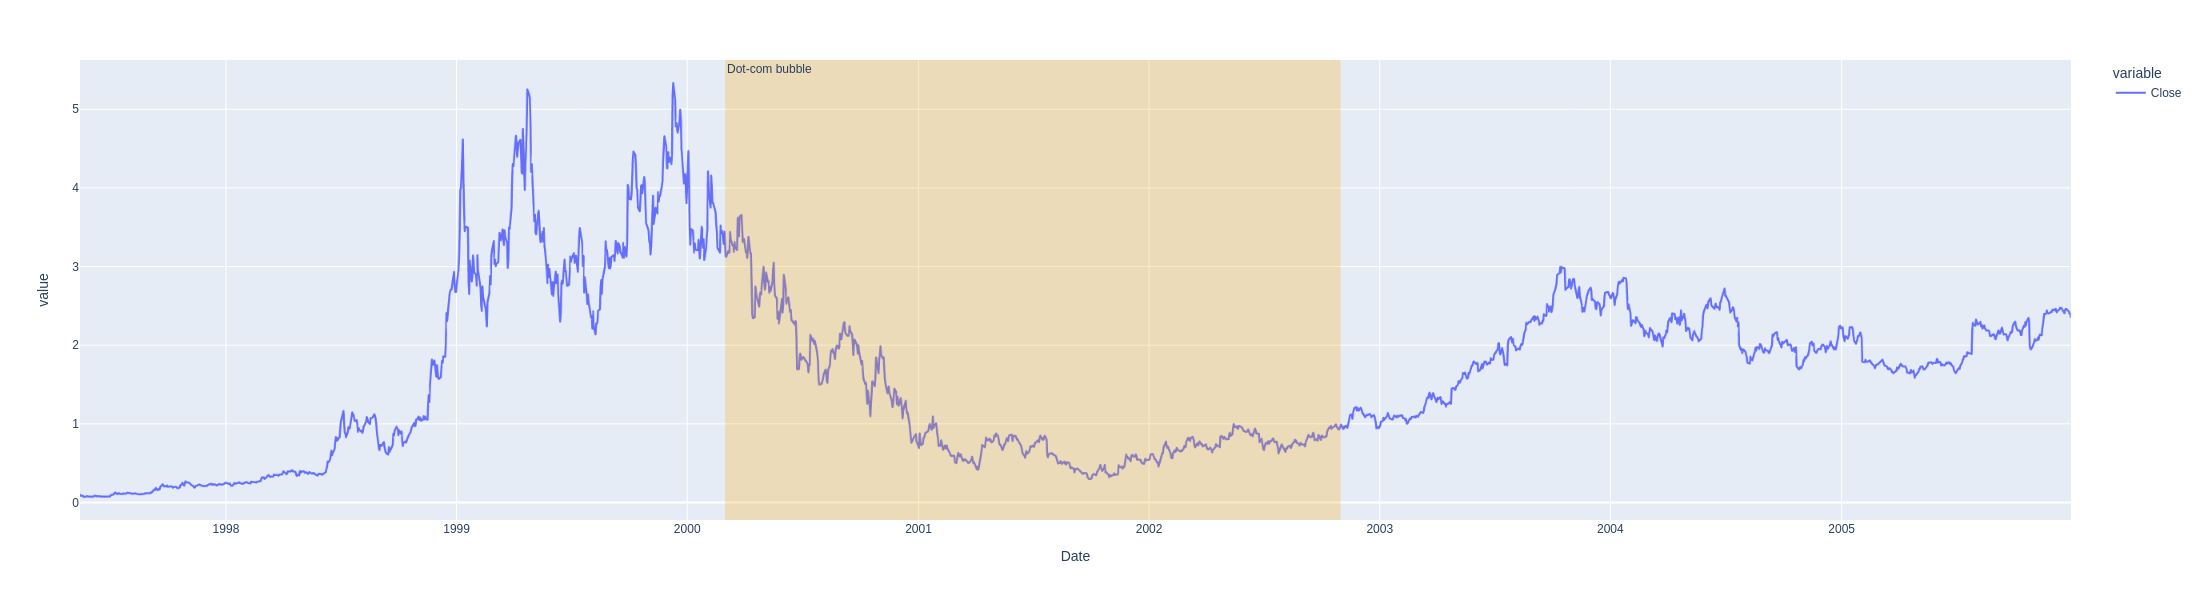

In [131]:
fig = px.line(amazon['Close']['1997-05-15':'2006-01-01'], width=2200, height=600)
fig.add_vrect(x0="2000-03-01", x1="2002-10-31", row="all", col=1,
              annotation_text="Dot-com bubble", annotation_position="top left",
              fillcolor="orange", opacity=0.25, line_width=0)
fig.show('png')

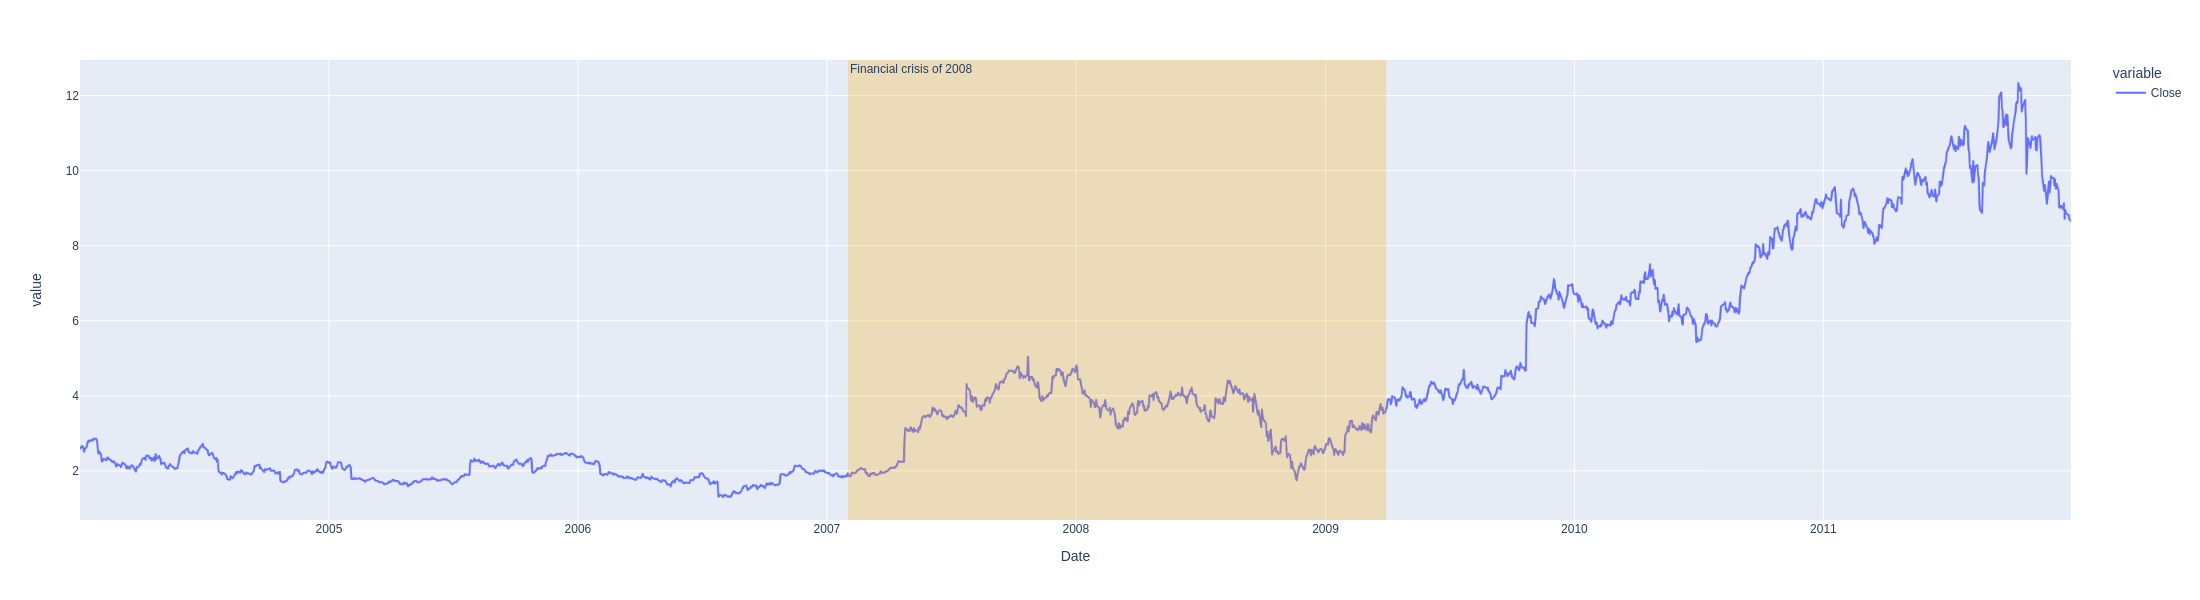

In [132]:
fig = px.line(amazon['Close']['2004-01-01':'2012-01-01'], width=2200, height=600)
fig.add_vrect(x0="2007-02-01", x1="2009-03-31", row="all", col=1,
              annotation_text="Financial crisis of 2008", annotation_position="top left",
              fillcolor="orange", opacity=0.25, line_width=0)
fig.show('png')

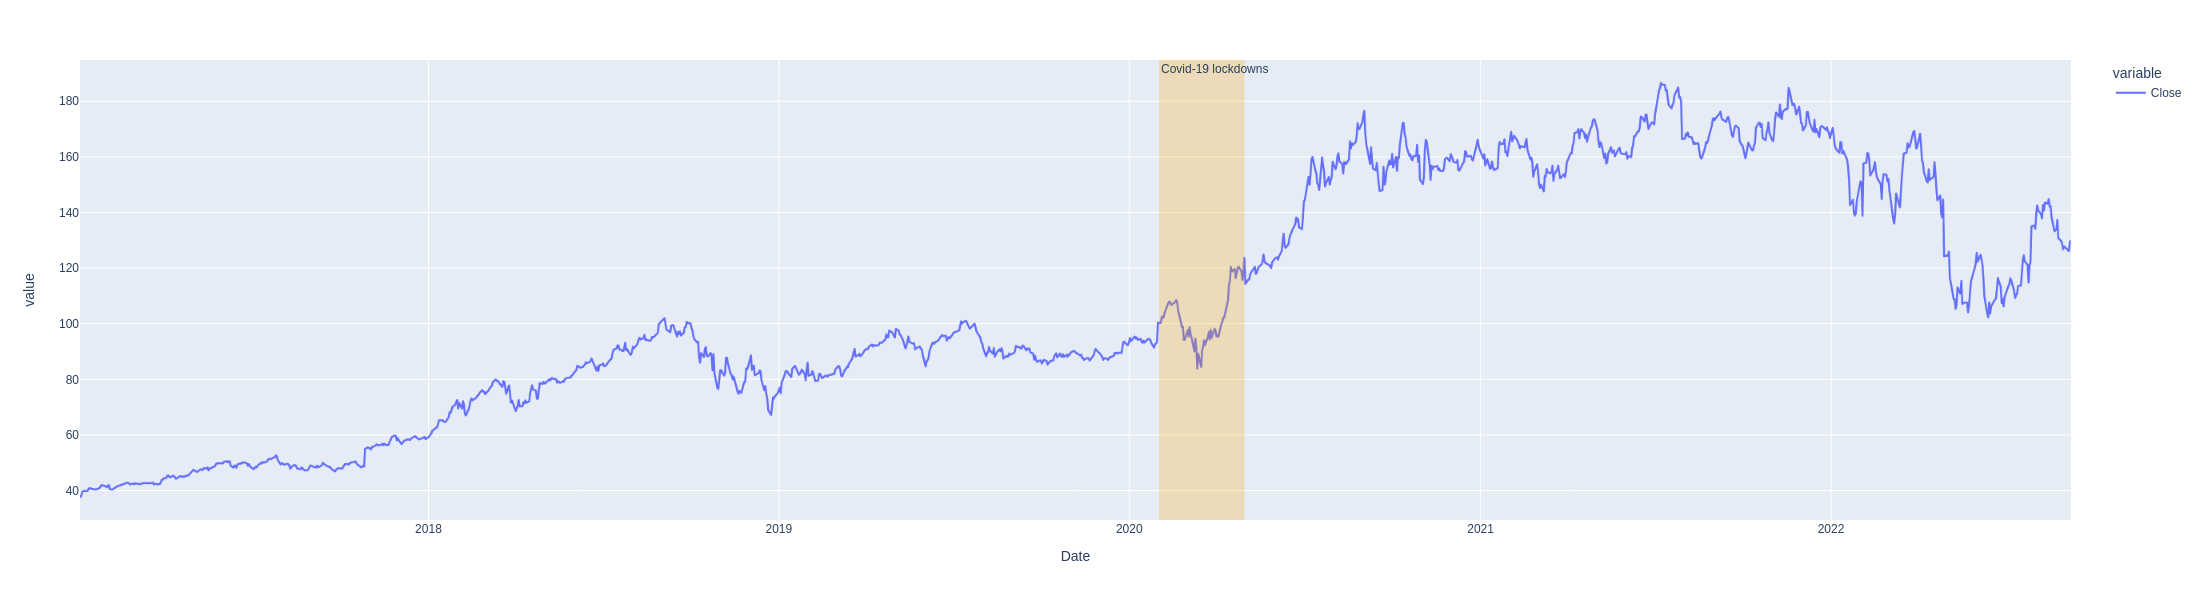

In [133]:
fig = px.line(amazon['Close']['2017-01-01':'2022-09-08'], width=2200, height=600)
fig.add_vrect(x0="2020-02-01", x1="2020-04-30", row="all", col=1,
              annotation_text="Covid-19 lockdowns", annotation_position="top left",
              fillcolor="orange", opacity=0.25, line_width=0)
fig.show('png')

We can see that Amazon's stock price was negatively impacted by the Dot-com bubble and COVID-19, but not so much by the Financial crisis

# Preparing the data

In [134]:
amazon[amazon['Dividends'] != 0]

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,


In [135]:
amazon[amazon['Stock Splits'] != 0]

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1998-06-02,0.363542,0.370833,0.345833,0.364063,164028000,0,2.0
1999-01-05,2.739063,3.243750,2.662500,3.112500,1257464000,0,3.0
1999-09-02,2.875000,3.096875,2.868750,3.003125,336774000,0,2.0
2022-06-06,125.250000,128.990005,123.809998,124.790001,135269000,0,20.0


In [136]:
del amazon["Dividends"]
del amazon["Stock Splits"]

In [137]:
amazon.head()

,Open,High,Low,Close,Volume
Date,,,,,
1997-05-15,0.121875,0.125000,0.096354,0.097917,1443120000
1997-05-16,0.098438,0.098958,0.085417,0.086458,294000000
1997-05-19,0.088021,0.088542,0.081250,0.085417,122136000
1997-05-20,0.086458,0.087500,0.081771,0.081771,109344000
1997-05-21,0.081771,0.082292,0.068750,0.071354,377064000


In [138]:
# Shift the closing stock price backward one day, so we're predicting tomorrow's stock prices (Actual_Close) from today's prices (Close)
amazon['Actual_Close'] = amazon['Close'].shift(-1)

In [139]:
# Identify the target that we're trying to predict - if the price went up, the target will be 1 and if it went down, the target will be 0.
amazon['Target'] = (amazon['Actual_Close'] > amazon['Close']).astype(int)

In [140]:
amazon

,Open,High,Low,Close,Volume,Actual_Close,Target
Date,,,,,,,
1997-05-15,0.121875,0.125000,0.096354,0.097917,1443120000,0.086458,0
1997-05-16,0.098438,0.098958,0.085417,0.086458,294000000,0.085417,0
1997-05-19,0.088021,0.088542,0.081250,0.085417,122136000,0.081771,0
1997-05-20,0.086458,0.087500,0.081771,0.081771,109344000,0.071354,0
1997-05-21,0.081771,0.082292,0.068750,0.071354,377064000,0.069792,0
...,...,...,...,...,...,...,...
2022-09-14,127.360001,128.839996,126.330002,128.550003,45316800,126.279999,0
2022-09-15,127.379997,130.369995,125.500000,126.279999,52887200,123.529999,0
2022-09-16,122.779999,123.870003,120.699997,123.529999,115612500,124.660004,1


In [141]:
# Drop the last row containing N/A
amazon = amazon.dropna()

# Creating a machine learning model

Because we're dealing with time series data, we can't just use cross-validation to create predictions for the whole dataset. This will cause leakage where data from the future will be used to predict past prices. This doesn't match with the real world, and will make us think that our algorithm is much better than it actually is.

Instead, we'll split the data sequentially. We'll start off by predicting just the last 100 rows using the other rows.

We'll use a random forest classifier to generate our predictions. This is a good "default" model for a lot of applications, because it can pick up nonlinear relationships in the data, and is somewhat robust to overfitting with the right parameters.

In [142]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Create a random forest classification model. Set min_samples_split high to ensure we don't overfit.
model = RandomForestClassifier(n_estimators=200, min_samples_split=100, random_state=1)

train = amazon.iloc[:-100]
test = amazon.iloc[-100:]

predictors = ["Actual_Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, n_estimators=200, random_state=1)

In [143]:
# We are using precision_score (which is a ration between tp / (tp + fp)) because for buying stock, we are not necesseraly interested if we get a false negative (Target 0, but the stock still goes up). We are not trying to maximise our return, but to minimize our losses 
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index, name='Predictions')
precision_score(test["Target"], preds)

0.54

The model is accurate at predicting the stock price direction 54% of the time - this is only a little better than a coin flip.

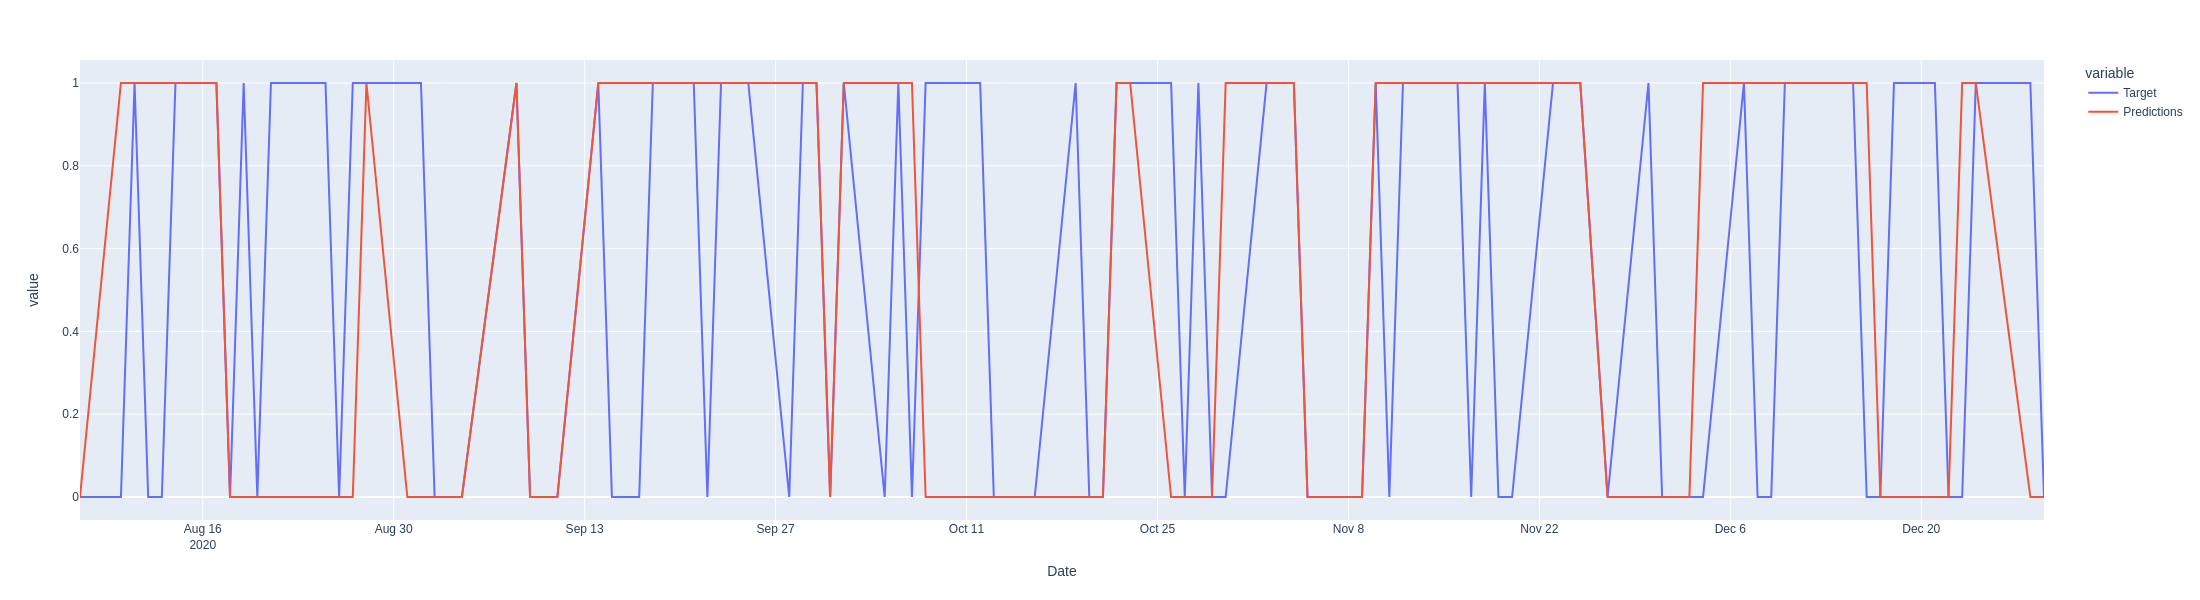

In [105]:
combined = pd.concat([test["Target"], preds], axis=1)
fig = px.line(combined, width=2200, height=600)
fig.show('png')

A few ways to improve this model would be to:

*   Adjust the parameters used in setting up the model 
*   Test a model against a longer period (now we are testing only against last 100 records)

In [144]:
combined[['Predictions']].value_counts()

Predictions
1              54
0              46
dtype: int64

# Backtesting

So far the model isn't great, but there are a few ways to improve it. Before we do that, let's figure out how to make predictions across the entire dataset, not just the last 100 rows. This will give us a more robust error estimate. The last 100 days may have had atypical market conditions or other issues that make error metrics on those days unrealistic for future predictions (which are what we really care about).

To do this, we'll need to backtest. Backtesting ensures that we only use data from before the day that we're predicting. If we use data from after the day we're predicting, the algorithm is unrealistic (in the real world, you won't be able to use future data to predict that past!).

Our backtesting method will loop over the dataset, and train a model every 750 rows. We'll make it a function so we can avoid rewriting the code if we want to backtest again.

In the backtesting function, we will:

*    Split the training and test data
*    Train a model
*    Make predictions on the test data using predict_proba - this is because we want to really optimize for true positives. By default, the threshold for splitting 0/1 is .5, but we can set it to different values to tweak the precision. If we set it too high, we'll make fewer trades, but will have a lower potential for losses.

In [145]:
def backtest(data, model, predictors, start=1000, step=750):
    predictions = []
    # Loop over the dataset in increments
    for i in range(start, data.shape[0], step):
        # Split into train and test sets
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()

        # Fit the random forest model
        model.fit(train[predictors], train["Target"])

        # Make predictions
        # We are using predict_proba, instead of predict previously. Predict gives either 0 or 1 as a prediction, while predict_proba gives a probability of both 0 and 1
        preds = model.predict_proba(test[predictors])[:,1] # We select the prediction only for 1 (since this gives the tuple prediction for 0 and 1) 
        preds = pd.Series(preds, index=test.index)
        preds[preds > .6] = 1
        preds[preds <= .6] = 0

        # Combine predictions and test values
        combined = pd.concat({"Target": test["Target"], "Predictions": preds}, axis=1)
        predictions.append(combined)
    
    return pd.concat(predictions)

In [146]:
predictions = backtest(amazon, model, predictors)

In [147]:
predictions

,Target,Predictions
Date,,
2001-05-03,1,1.0
2001-05-04,0,0.0
2001-05-07,0,0.0
2001-05-08,0,0.0
2001-05-09,0,0.0
...,...,...
2022-09-13,1,1.0
2022-09-14,0,1.0
2022-09-15,0,1.0


We can see that we made only 453 trades - mostly because we used 0.6 as treshold for training. The model's accuracy has increased to 66%

In [148]:
predictions["Predictions"].value_counts()

0.0    4926
1.0     453
Name: Predictions, dtype: int64

In [149]:
precision_score(predictions["Target"], predictions["Predictions"])

0.6644591611479028

# Improving accuracy

The model isn't very accurate, but at least now we can make predictions across the entire history of the stock. For this model to be useful, we can add some more predictors to see if we can improve accuracy.

We'll add in some rolling means, so the model can evaluate the current price against recent prices. We'll also look at the ratios between different indicators.

In [150]:
weekly_mean = amazon.rolling(7).mean()
quarterly_mean = amazon.rolling(90).mean()
annual_mean = amazon.rolling(365).mean()
weekly_trend = amazon.shift(1).rolling(7).mean()["Target"]

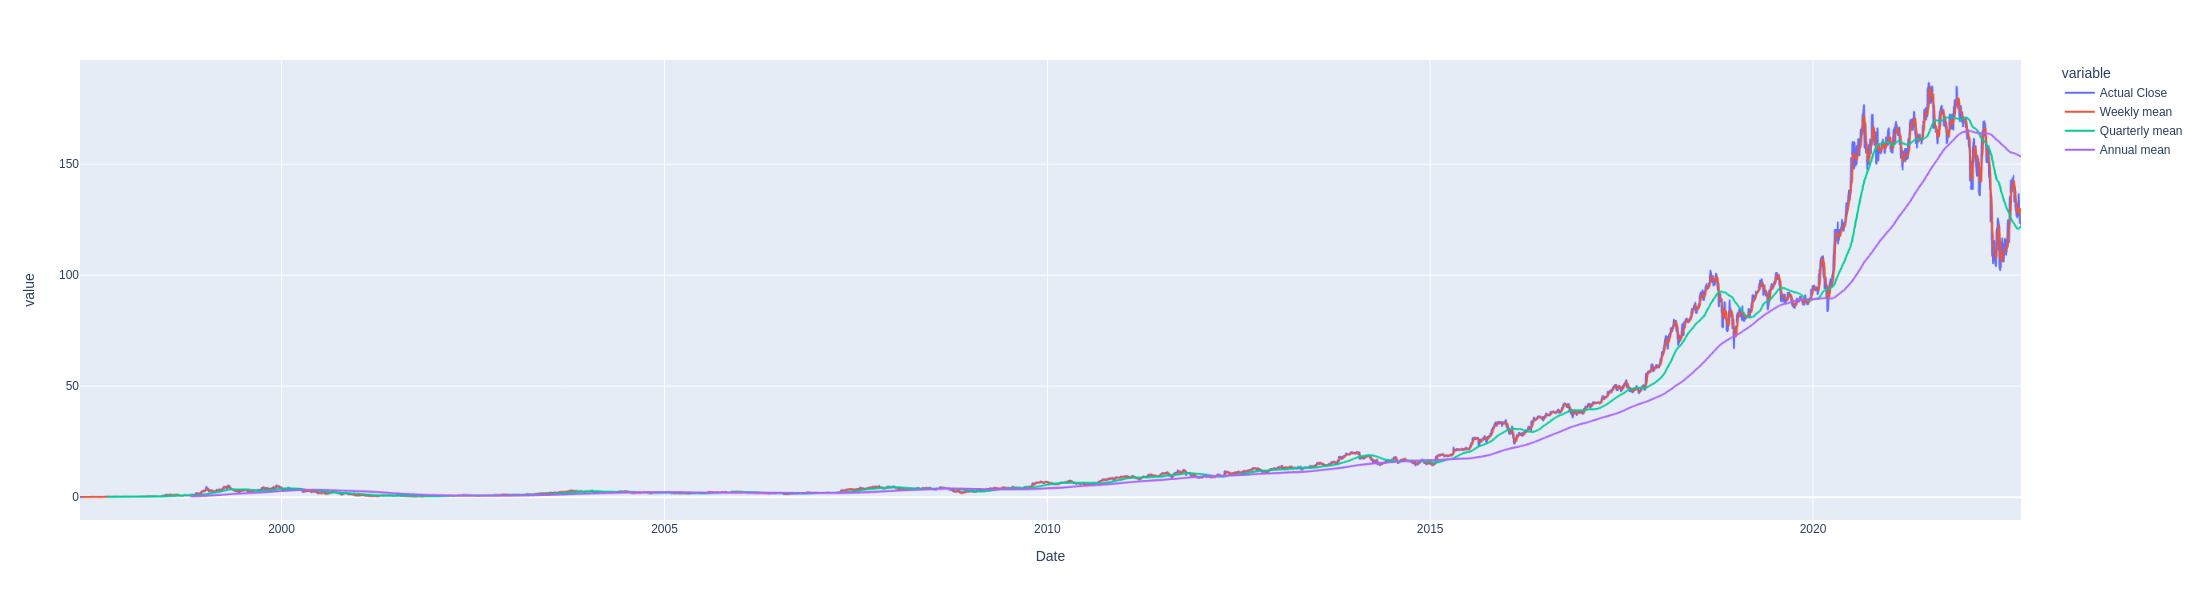

In [151]:
df_close_mean = pd.concat([amazon['Actual_Close'], weekly_mean['Actual_Close'], quarterly_mean['Actual_Close'], annual_mean['Actual_Close']], axis=1, keys= ['Actual Close', 'Weekly mean', 'Quarterly mean', 'Annual mean'])
fig = px.line(df_close_mean, width=2200, height=600)
fig.show('png')

In [152]:
pd.options.mode.chained_assignment = None  # default='warn'
amazon["weekly_mean"] = weekly_mean["Actual_Close"] / amazon["Actual_Close"]
amazon["quarterly_mean"] = quarterly_mean["Actual_Close"] / amazon["Actual_Close"]
amazon["annual_mean"] = annual_mean["Actual_Close"] / amazon["Actual_Close"]

amazon["annual_weekly_mean"] = amazon["annual_mean"] / amazon["weekly_mean"]
amazon["annual_quarterly_mean"] = amazon["annual_mean"] / amazon["quarterly_mean"]
amazon["weekly_trend"] = weekly_trend

amazon["open_close_ratio"] = amazon["Open"] / amazon["Actual_Close"]
amazon["high_close_ratio"] = amazon["High"] / amazon["Actual_Close"]
amazon["low_close_ratio"] = amazon["Low"] / amazon["Actual_Close"]


In [153]:
amazon

,Open,High,Low,Close,Volume,Actual_Close,Target,weekly_mean,quarterly_mean,annual_mean,annual_weekly_mean,annual_quarterly_mean,weekly_trend,open_close_ratio,high_close_ratio,low_close_ratio
Date,,,,,,,,,,,,,,,,
1997-05-15,0.121875,0.125000,0.096354,0.097917,1443120000,0.086458,0,NaN,NaN,NaN,NaN,NaN,NaN,1.409644,1.445789,1.114460
1997-05-16,0.098438,0.098958,0.085417,0.086458,294000000,0.085417,0,NaN,NaN,NaN,NaN,NaN,NaN,1.152440,1.158528,1.000000
1997-05-19,0.088021,0.088542,0.081250,0.085417,122136000,0.081771,0,NaN,NaN,NaN,NaN,NaN,NaN,1.076433,1.082804,0.993628
1997-05-20,0.086458,0.087500,0.081771,0.081771,109344000,0.071354,0,NaN,NaN,NaN,NaN,NaN,NaN,1.211677,1.226280,1.145990
1997-05-21,0.081771,0.082292,0.068750,0.071354,377064000,0.069792,0,NaN,NaN,NaN,NaN,NaN,NaN,1.171639,1.179104,0.985070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-13,131.009995,131.399994,126.269997,126.820000,72694000,128.550003,1,1.011835,0.942881,1.196698,1.182701,1.269194,0.571429,1.019136,1.022170,0.982264
2022-09-14,127.360001,128.839996,126.330002,128.550003,45316800,126.279999,0,1.030216,0.960843,1.217453,1.181745,1.267068,0.714286,1.008552,1.020272,1.000396
2022-09-15,127.379997,130.369995,125.500000,126.279999,52887200,123.529999,0,1.046270,0.983559,1.243659,1.188659,1.264448,0.714286,1.031167,1.055371,1.015948


In [154]:
full_predictors = predictors + ["weekly_mean", "quarterly_mean", "annual_mean", "annual_weekly_mean", "annual_quarterly_mean", "open_close_ratio", "high_close_ratio", "low_close_ratio", "weekly_trend"]
predictions = backtest(amazon.iloc[365:], model, full_predictors)

In [155]:
precision_score(predictions["Target"], predictions["Predictions"])

0.9270038167938931

In [156]:
# Show how many trades we would make
predictions["Predictions"].value_counts()

0.0    2918
1.0    2096
Name: Predictions, dtype: int64

We can see that we are making less trades than our target - this is expected, and consistent with the model's aim to be conservative and minimize losses

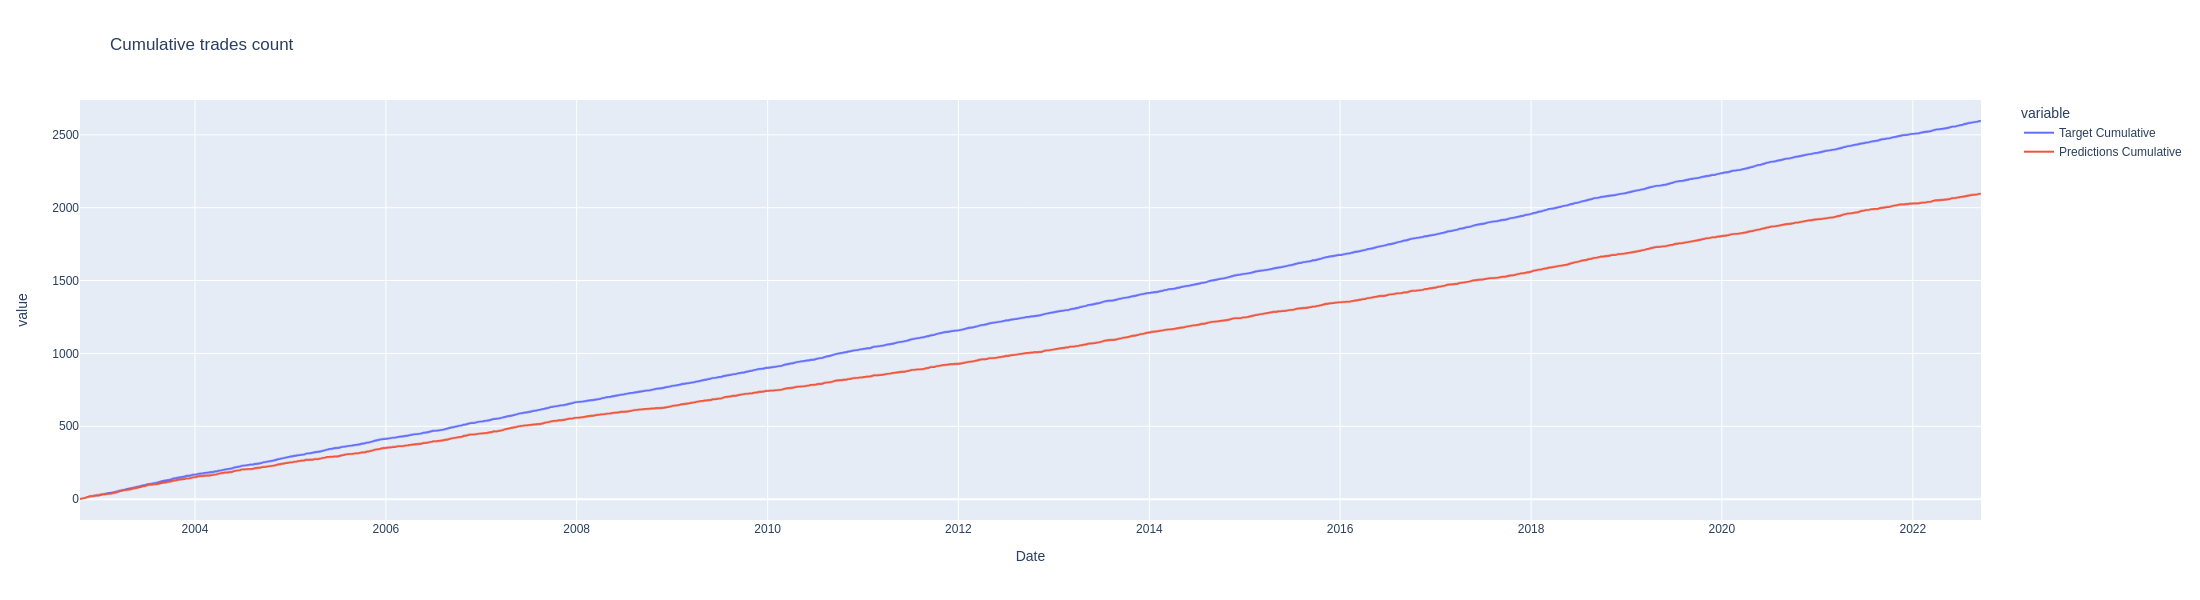

In [158]:
predictions_visual = predictions.copy()
predictions_visual['Target Cumulative'] = predictions_visual['Target'].cumsum()
predictions_visual['Predictions Cumulative'] = predictions_visual['Predictions'].cumsum()
fig = px.line(predictions_visual[['Target Cumulative','Predictions Cumulative']], title="Cumulative trades count", width=2200, height=600)
fig.show('png')

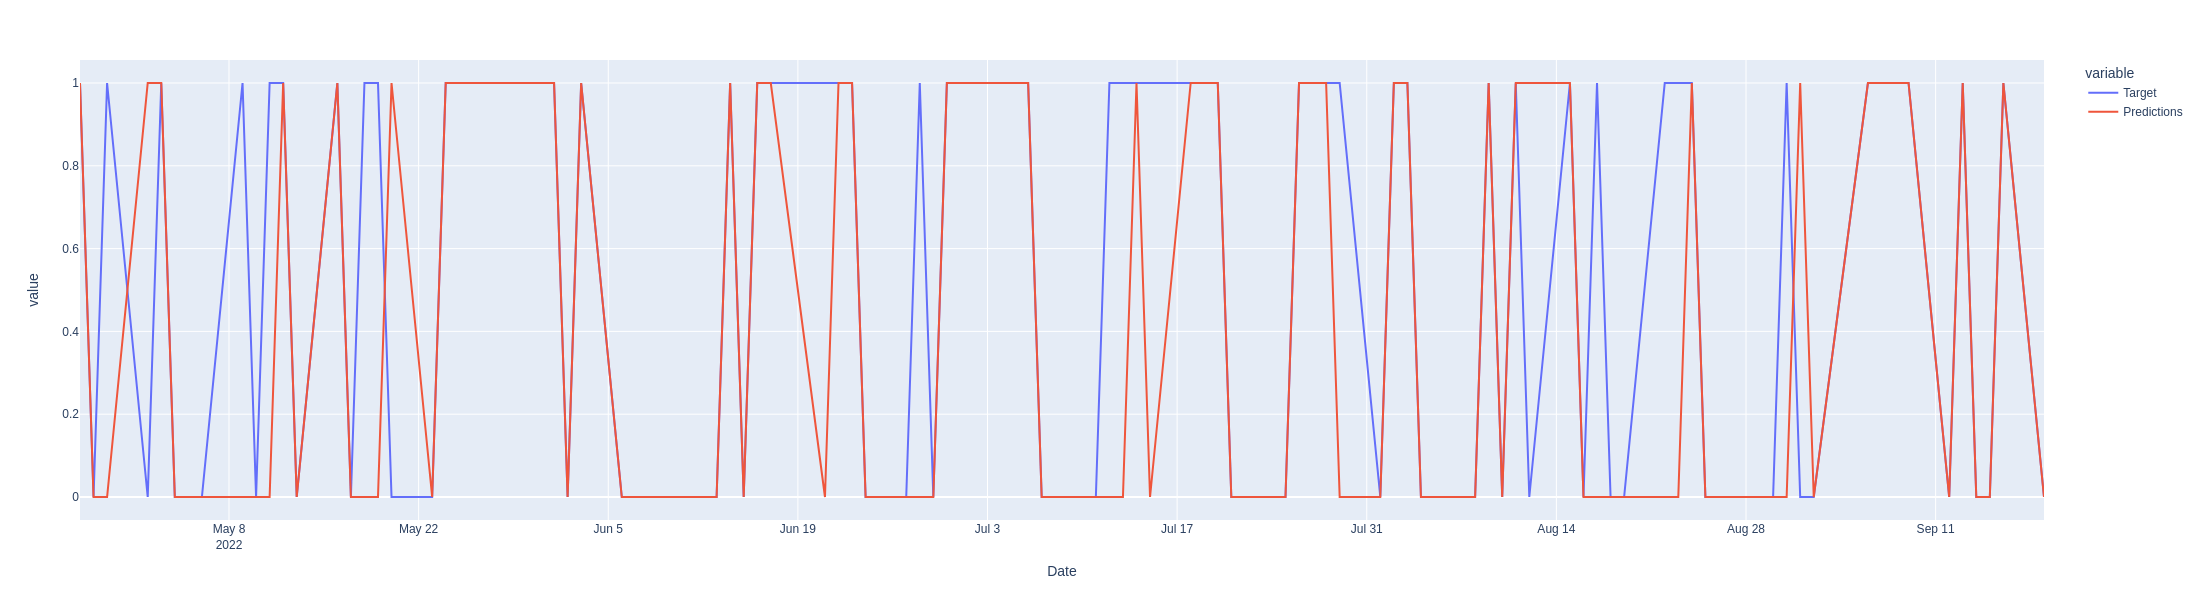

In [159]:
fig = px.line(predictions.iloc[-100:], width=2200, height=600)
fig.show('png')

# Test how much money we would have made using the algorithm

We will test how good the model is on data that it hasn't seen before - from 2021-01-01 to 2022-08-31. This will allow us to really see the effectiveness of this model

In [160]:
# Calculate the investment return using the algorith vs. just holding the stock 
investment = amazon['2020-01-01':]['Close']
investment = pd.concat([investment, predictions['Predictions'].iloc[-investment.shape[0]:]], axis=1)

# Calculate the return on $1,000 investment without algorithm
investment['Stocks_without_algorithm'] = (1000/investment['Close'].iloc[0])
investment['Stocks_without_algorithm'] = investment['Stocks_without_algorithm']
investment['Value_without_algorithm'] = round(investment['Stocks_without_algorithm'] * investment['Close'],2)

# Calculate the return on $1,000 investment with using the algorithm
investment['Stocks_algorithm'] = 0
investment['Value_algorithm'] = 1000
investment['Stocks_algorithm'][0] = investment['Value_algorithm'][0] / investment['Close'][0]

for i in range(1, investment['Predictions'].shape[0]):
  if investment['Predictions'].iloc[i] > 0:
    if investment['Predictions'].iloc[i-1] == 0:
      investment['Stocks_algorithm'].iloc[i] = investment['Value_algorithm'].iloc[i-1] / investment['Close'].iloc[i-1]
      investment['Value_algorithm'].iloc[i] = investment['Stocks_algorithm'].iloc[i] * investment['Close'].iloc[i]
    else:
      investment['Stocks_algorithm'].iloc[i] = investment['Stocks_algorithm'].iloc[i-1]
      investment['Value_algorithm'].iloc[i] = investment['Stocks_algorithm'].iloc[i] * investment['Close'].iloc[i]
  
  elif investment['Predictions'].iloc[i] == 0:
    investment['Value_algorithm'].iloc[i] = investment['Stocks_algorithm'].iloc[i-1] * investment['Close'].iloc[i]
    investment['Stocks_algorithm'].iloc[i] = 0
    if investment['Stocks_algorithm'].iloc[i-1] == 0:
      investment['Value_algorithm'].iloc[i] = investment['Value_algorithm'].iloc[i-1]

investment['Value_algorithm'] = round(investment['Value_algorithm'],2)

In [161]:
investment

,Close,Predictions,Stocks_without_algorithm,Value_without_algorithm,Stocks_algorithm,Value_algorithm
Date,,,,,,
2020-01-02,94.900497,0.0,10.537353,1000.00,10.000000,1000.00
2020-01-03,93.748497,1.0,10.537353,987.86,10.537353,987.86
2020-01-06,95.143997,1.0,10.537353,1002.57,10.537353,1002.57
2020-01-07,95.343002,0.0,10.537353,1004.66,0.000000,1004.66
2020-01-08,94.598503,0.0,10.537353,996.82,0.000000,1004.66
...,...,...,...,...,...,...
2022-09-13,126.820000,1.0,10.537353,1336.35,521.243282,66104.07
2022-09-14,128.550003,0.0,10.537353,1354.58,0.000000,67005.83
2022-09-15,126.279999,0.0,10.537353,1330.66,0.000000,67005.83


Below is the visualization of the cumulative returns if we have invested 1,000 USD in the Amazon stock on 2020-01-02. Without using the algorithm, our initial investment of USD 1,000 would have been worth around 1,364 USD - that's a 36,4% increase

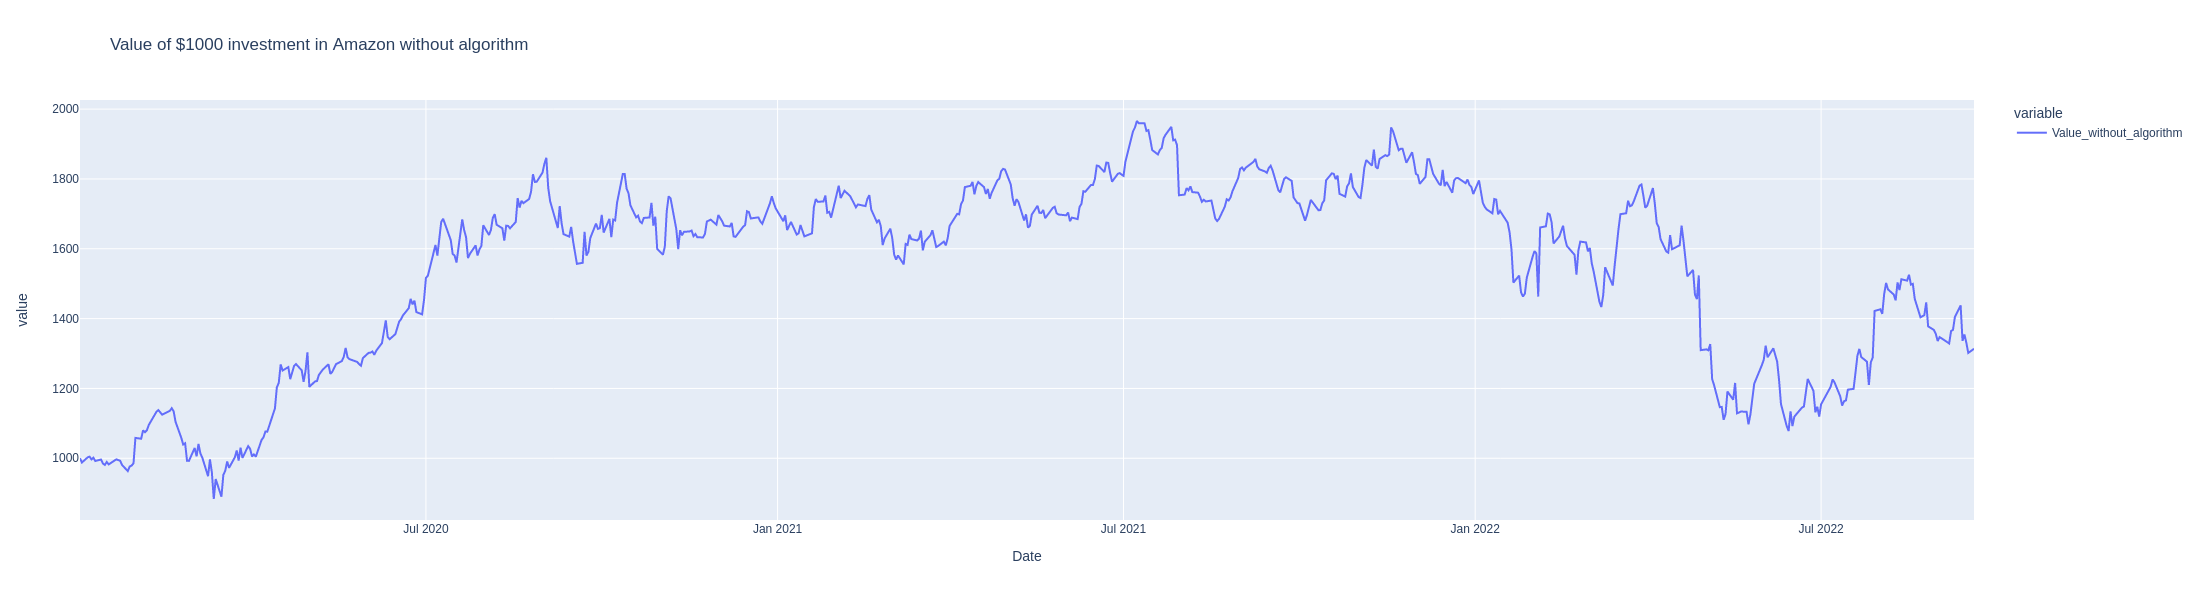

In [165]:
fig = px.line(investment['Value_without_algorithm'], title="Value of $1000 investment in Amazon without algorithm", width=2200, height=600)
fig.show('png')

Hoewever, the return using the algorithm (i.e. buying the stock when the algorithm predicts a price increase next day, and selling the stock when the algorithm predicts a price drop next day) would be around USD 67,490 - that's more than 67,000% increase!

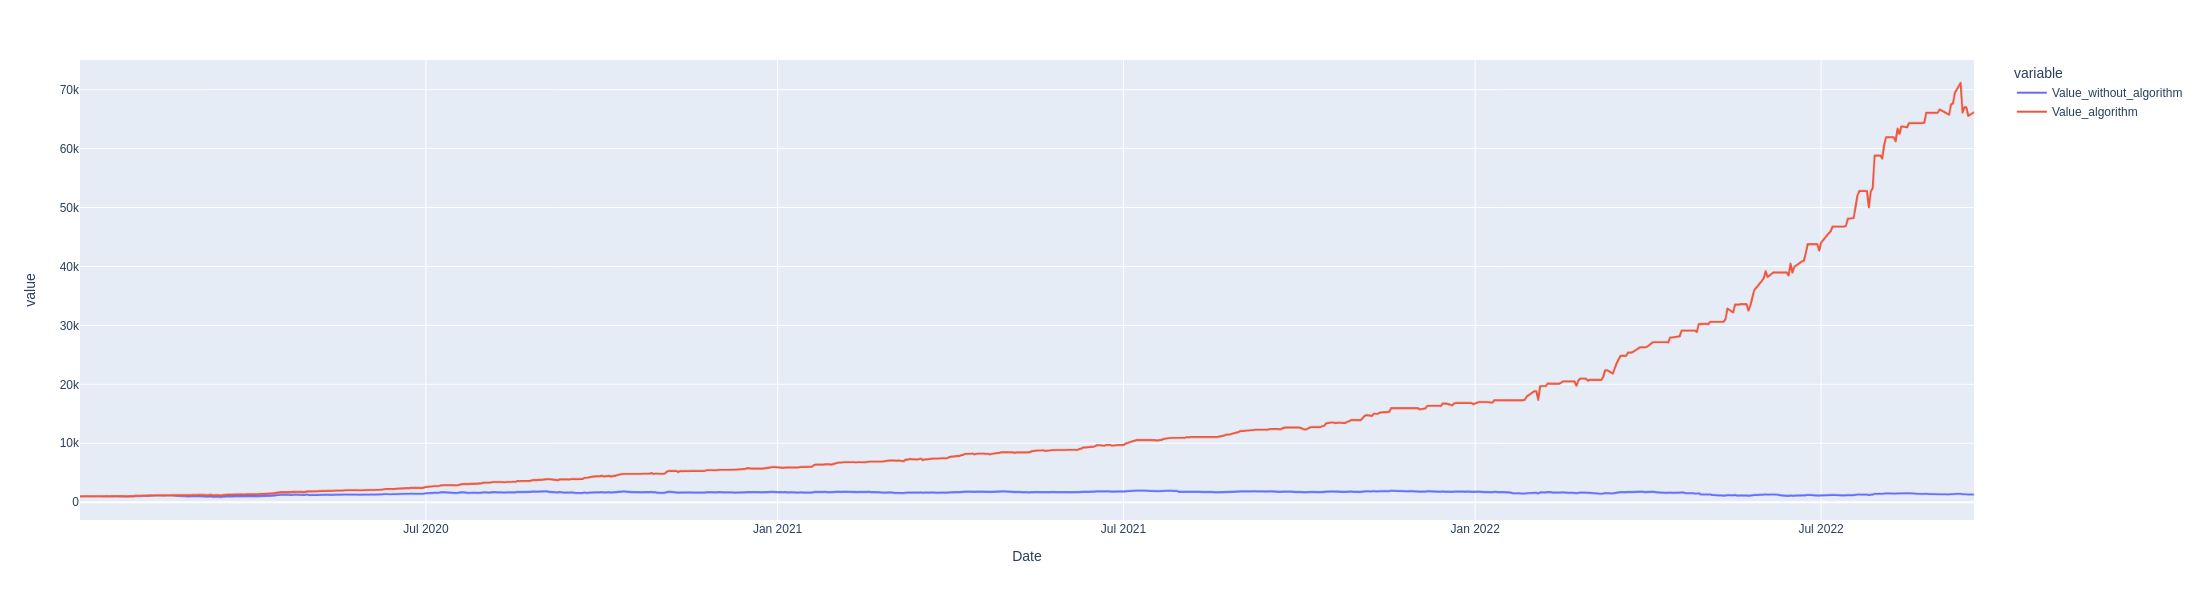

In [166]:
fig = px.line(investment[['Value_without_algorithm', 'Value_algorithm']], width=2200, height=600)
fig.show('png')

# Next steps
In this project we downloaded and cleaned data, added visualizations and setup a backtesting engine. We see that the algorithm performs very well - however, is it realistic that this algorithm would generalize well in the real world, and also with other stocks? 

Realistically, predicting a stock price just from price and volume data is a bit optimistic - the stock market is very complex and can be impacted by a plethora of events. To make this model more robust, we should add more predictors and continue to improve the accuracy of the model.

## Add in more predictors
-   Account for activity post-close and pre-open
      *   Early trading
      *   Trading on other exchanges that open before the NYSE (to see what the global sentiment is)
-   Economic indicators
      *   Interest rates
      *   Other important economic news
-   Key dates
      *   Dividends
      *   External factors like elections
-   Company milestones
      *   Earnings calls
      *   Analyst ratings
      *   Major announcements
-   Prices of related stocks
      *   Other companies in the same sector
      *   Key partners, customers, etc.


## Improve the algorithm
-   Run with a reduced step size. This will take longer, but increase accuracy
-   Try discarding older data (only keeping data in a certain window)
-   Try a different machine learning algorithm
-   Tweak random forest parameters, or the prediction threshold